In [1]:
%matplotlib inline
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning
from sklearn.metrics import accuracy_score

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [38]:
# Import data
test_features = pd.read_csv('test_features.csv')
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')

# assign to train, test, and submission
X_train = train_features.drop(columns='id')
X_test = test_features.drop(columns='id')
y_train = train_labels.drop(columns='id')
submission = test_features[['id']]

X_train.shape, X_test.shape, y_train.shape

((59400, 39), (14358, 39), (59400, 1))

In [39]:
# Split training data into train, validate. Make the validation set the same shape of the test set.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=len(X_test), stratify=y_train, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((45042, 39), (14358, 39), (45042, 1), (14358, 1))

### Data cleaning, feature engineering, and categorical encoding

In [41]:
def wrangle(X):
    # Create copy of dataframe to avoid copy warning
    X = X.copy()
    
    # Some features have missing data showing as 0 that need to be changed to nan
    X['gps_height'] = X['gps_height'].replace(0.0, np.nan)
    X['longitude'] = X['longitude'].replace(0.0, np.nan)
    X['latitude'] = X['latitude'].replace(0.0, np.nan)
    X['construction_year'] = X['construction_year'].replace(0.0, np.nan)
    X['population'] = X['population'].replace(0.0, np.nan)
    X['amount_tsh'] = X['amount_tsh'].replace(0.0, np.nan)
    
    # gps_height: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['gps_height'].fillna(X.groupby(['ward'])['gps_height'].transform('mean'), inplace=True)
    X['gps_height'].fillna(X.groupby(['district_code'])['gps_height'].transform('mean'), inplace=True)
    X['gps_height'].fillna(X.groupby(['region_code'])['gps_height'].transform('mean'), inplace=True)
    X['gps_height'].fillna(X['gps_height'].mean(), inplace=True)
    
    # longitude: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['longitude'].fillna(X.groupby(['ward'])['longitude'].transform('mean'), inplace=True)
    X['longitude'].fillna(X.groupby(['district_code'])['longitude'].transform('mean'), inplace=True)
    X['longitude'].fillna(X.groupby(['region_code'])['longitude'].transform('mean'), inplace=True)
    X['longitude'].fillna(X['longitude'].mean(), inplace=True)
    
    # latitude: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['latitude'].fillna(X.groupby(['ward'])['latitude'].transform('mean'), inplace=True)
    X['latitude'].fillna(X.groupby(['district_code'])['latitude'].transform('mean'), inplace=True)
    X['latitude'].fillna(X.groupby(['region_code'])['latitude'].transform('mean'), inplace=True)
    X['latitude'].fillna(X['latitude'].mean(), inplace=True)
    
    # population: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['population'].fillna(X.groupby(['ward'])['population'].transform('median'), inplace=True)
    X['population'].fillna(X.groupby(['district_code'])['population'].transform('median'), inplace=True)
    X['population'].fillna(X.groupby(['region_code'])['population'].transform('median'), inplace=True)
    X['population'].fillna(X['population'].median(), inplace=True)
    
    # population: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['amount_tsh'].fillna(X.groupby(['ward'])['amount_tsh'].transform('median'), inplace=True)
    X['amount_tsh'].fillna(X.groupby(['district_code'])['amount_tsh'].transform('median'), inplace=True)
    X['amount_tsh'].fillna(X.groupby(['region_code'])['amount_tsh'].transform('median'), inplace=True)
    X['amount_tsh'].fillna(X['amount_tsh'].median(), inplace=True)
    
    # construction_year: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['construction_year'].fillna(X.groupby(['ward'])['construction_year'].transform('median'), inplace=True)
    X['construction_year'].fillna(X.groupby(['district_code'])['construction_year'].transform('median'), inplace=True)
    X['construction_year'].fillna(X.groupby(['region_code'])['construction_year'].transform('median'), inplace=True)
    X['construction_year'].fillna(X['construction_year'].median(), inplace=True)
    
    # Convert date to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract datetime data
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # Drop duplicate or unnecessary features
    X = X.drop(columns=['recorded_by', 'quantity_group', 'date_recorded', 'wpt_name', 'num_private', 'subvillage',
                       'region_code', 'district_code', 'management_group', 'extraction_type_group', 'extraction_type_class',
                       'scheme_name', 'payment', 'water_quality', 'source_type', 'source_class', 'waterpoint_type_group',
                       'ward', 'public_meeting', 'permit'])
    
    # Several categorical features have values showing as '0'
    # Replace '0' with nan
    categoricals = X.select_dtypes(exclude='number').columns.tolist()
    X[categoricals] = X[categoricals].replace('0', np.nan)
    
    # Convert to lowercase to collapse duplicates
    X['waterpoint_type'] = X['waterpoint_type'].str.lower()
    X['funder'] = X['funder'].str.lower()
    X['basin'] = X['basin'].str.lower()
    X['region'] = X['region'].str.lower()
    X['source'] = X['source'].str.lower()
    X['lga'] = X['lga'].str.lower()
    X['management'] = X['management'].str.lower()
    X['quantity'] = X['quantity'].str.lower()
    X['quality_group'] = X['quality_group'].str.lower()
    X['payment_type'] = X['payment_type'].str.lower()
    X['extraction_type'] = X['extraction_type'].str.lower()
    
    # Replace nan values with 'other'
    X["funder"].fillna("other", inplace=True)
    X["scheme_management"].fillna("other", inplace=True)
    X["installer"].fillna("other", inplace=True)
    
    X = X.replace(np.nan, 'other')
    
    return X

In [42]:
def feature_eng(X):
    X = X.copy()
    
    # Engineered features from data exploration and cleaning notebook
    X['amount_tsh_above_1000'] = X['amount_tsh'] > 1000
    X['water_quality_good_and_seasonal'] = (X['quality_group'] == 'good') & (X['quantity'] == 'seasonal')
    X['water_quality_good_and_dry'] = (X['quality_group'] == 'good') & (X['quantity'] == 'dry')
    X['water_quality_good_and_insufficient'] = (X['quality_group'] == 'good') & (X['quantity'] == 'insufficient')
    X['water_quality_good_and_enough'] = (X['quality_group'] == 'good') & (X['quantity'] == 'enough')
    X['water_quality_good'] = X['quality_group'] == 'good'
    X['age'] = 2019 - X['construction_year']
    X['years_since_inspection'] = 2019 - X['year_recorded']
    X['x_coordinate'] = np.cos(X['latitude'] * np.cos(X['longitude']))
    X['y_coordinate'] = np.cos(X['latitude'] * np.sin(X['longitude']))
    X['z_coordinate'] = np.sin(X['latitude'])
    
    return X

In [43]:
def encode(X_train, X_val, X_test):
    X_train = X_train.copy()
    X_val = X_val.copy()
    X_test = X_test.copy()
    encoder = ce.OrdinalEncoder()
    X_train = encoder.fit_transform(X_train)
    X_val = encoder.transform(X_val)
    X_test = encoder.transform(X_test)
    
    return X_train, X_val, X_test

In [44]:
# run wrangle function
X_train = wrangle(X_train)
X_val = wrangle(X_val)
X_test = wrangle(X_test)

X_train.shape, X_val.shape, X_test.shape

((45042, 20), (14358, 20), (14358, 20))

In [45]:
# run feature_eng function
X_train = feature_eng(X_train)
X_val = feature_eng(X_val)
X_test = feature_eng(X_test)

X_train.shape, X_val.shape, X_test.shape

((45042, 31), (14358, 31), (14358, 31))

In [10]:
# run encode function
X_train, X_val, X_test = encode(X_train, X_val, X_test)

X_train.shape, X_val.shape, X_test.shape

((45042, 31), (14358, 31), (14358, 31))

### Run model

In [11]:
# Set model params
model = RandomForestClassifier(criterion='entropy', max_features=4, n_estimators=251, n_jobs=-1, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_val)

# Check score
score = accuracy_score(y_val, y_pred)
score

0.8095138598690625

### Plot feature importances

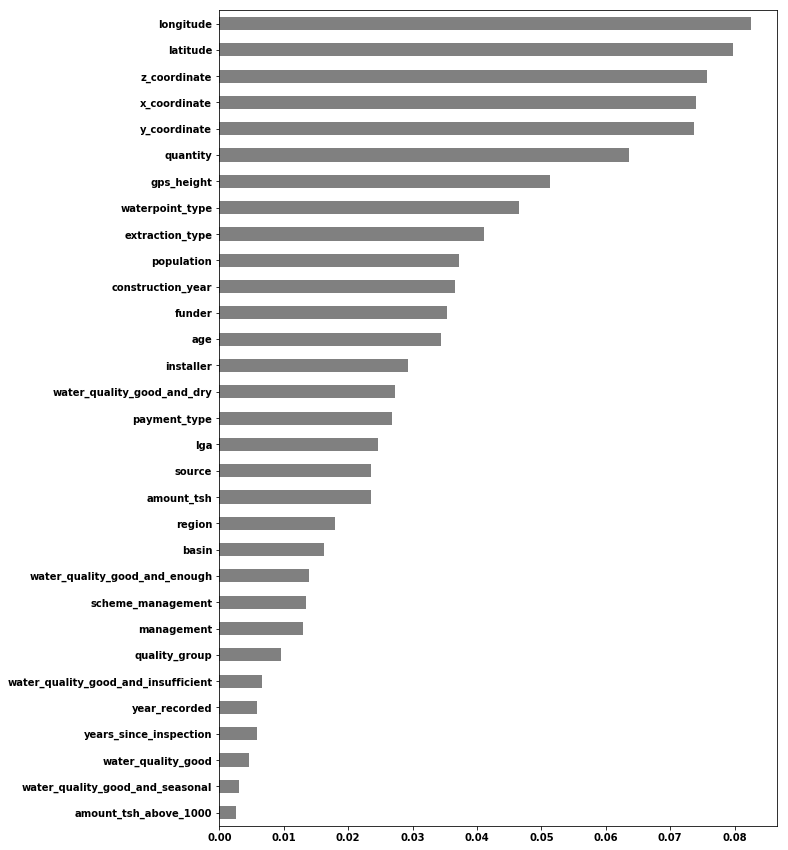

In [12]:
importances = pd.Series(model.feature_importances_, X_train.columns)
n = len(X_train.columns)
top_n = importances.sort_values()[-n:]
plt.figure(figsize=(10, 15))
top_n.plot.barh(color='gray');

### Permutation importances

In [13]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='accuracy', cv='prefit', random_state=42)

permuter.fit(X_val.values, y_val)

PermutationImportance(cv='prefit',
           estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=251, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
           n_iter=5, random_state=42, refit=True, scoring='accuracy')

In [14]:
feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0535 ± 0.0030,quantity
0.0262 ± 0.0049,waterpoint_type
0.0169 ± 0.0040,extraction_type
0.0094 ± 0.0020,payment_type
0.0064 ± 0.0017,population
0.0054 ± 0.0028,water_quality_good_and_dry
0.0039 ± 0.0017,source
0.0031 ± 0.0017,water_quality_good_and_enough
0.0027 ± 0.0015,longitude
0.0020 ± 0.0023,region


In [15]:
def con_matrix_analysis(model, feature_matrix, target_vector):
  from sklearn.metrics import classification_report, confusion_matrix
  
  x = model.predict(feature_matrix)
  y = target_vector
  
  print(classification_report(y, x,
        target_names=['Functional', 'Needs Repair', 'Not-Functional']))

  con_matrix = pd.DataFrame(confusion_matrix(y, x), 
             columns=['Predicted Functional', 'Predicted Needs Repair', 'Predicted Not-Functional'], 
             index=['Actual Functional', 'Actual Needs Repair', 'Actual Not-Functional'])

  return con_matrix
                            
con_matrix_analysis(model, X_val, y_val)

                precision    recall  f1-score   support

    Functional       0.81      0.89      0.85      7798
  Needs Repair       0.55      0.33      0.41      1043
Not-Functional       0.85      0.78      0.81      5517

     micro avg       0.81      0.81      0.81     14358
     macro avg       0.73      0.67      0.69     14358
  weighted avg       0.80      0.81      0.80     14358



,Predicted Functional,Predicted Needs Repair,Predicted Not-Functional
Actual Functional,6976,193,629
Actual Needs Repair,544,344,155
Actual Not-Functional,1128,86,4303


### Location clustering

In [46]:
train = pd.concat([X_train, y_train], axis='columns')
val = pd.concat([X_val, y_val], axis='columns')

train.shape, val.shape

((45042, 32), (14358, 32))

In [17]:
train.groupby('quantity')['status_group'].value_counts(normalize=True)

quantity  status_group           
1         non functional             0.967707
          functional                 0.026091
          functional needs repair    0.006202
2         functional                 0.522510
          non functional             0.381888
          functional needs repair    0.095602
3         functional                 0.650004
          non functional             0.277495
          functional needs repair    0.072501
4         functional                 0.583008
          non functional             0.317057
          functional needs repair    0.099935
5         non functional             0.705980
          functional                 0.274086
          functional needs repair    0.019934
Name: status_group, dtype: float64

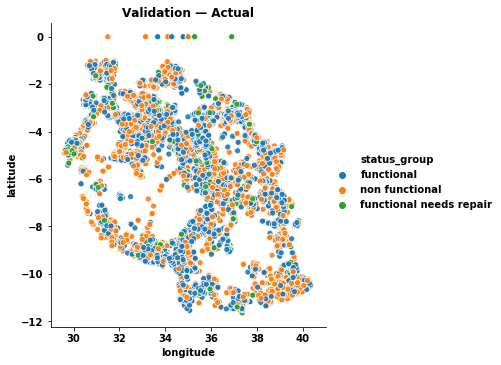

In [18]:
sns.relplot(x='longitude', y='latitude', hue='status_group', data=val, alpha=0.9, 
            hue_order=['functional', 'non functional', 'functional needs repair'])
plt.xlim(29,41)
plt.title('Validation — Actual');

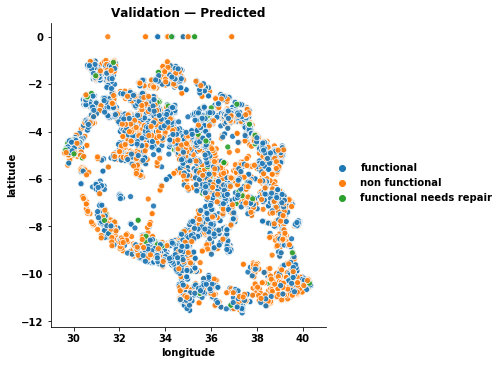

In [19]:
y_pred = model.predict(X_val)
sns.relplot(x='longitude', y='latitude', hue=y_pred, data=val, alpha=0.9, 
            hue_order=['functional', 'non functional', 'functional needs repair'])
plt.xlim(29,41)
plt.title('Validation — Predicted');

<Figure size 432x288 with 0 Axes>

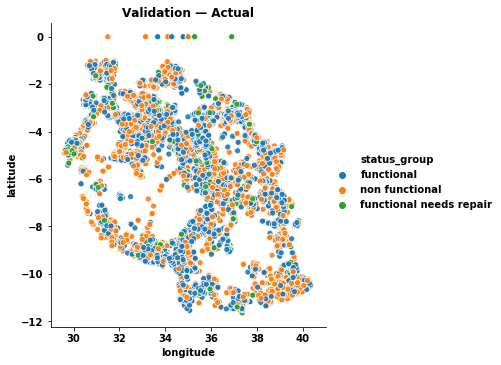

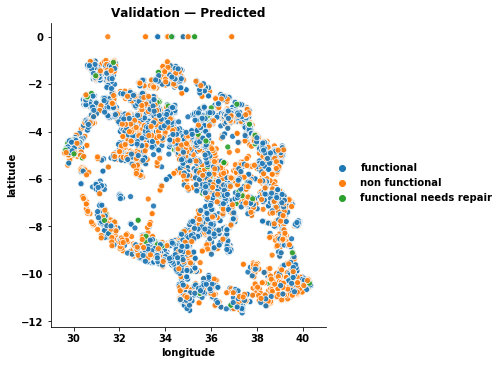

In [20]:
plt.tight_layout()

sns.relplot(x='longitude', y='latitude', hue='status_group', data=val, alpha=0.9, 
            hue_order=['functional', 'non functional', 'functional needs repair'])
plt.xlim(29,41)
plt.title('Validation — Actual');

y_pred = model.predict(X_val)
sns.relplot(x='longitude', y='latitude', hue=y_pred, data=val, alpha=0.9, 
            hue_order=['functional', 'non functional', 'functional needs repair'])
plt.xlim(29,41)
plt.title('Validation — Predicted');

In [21]:
train['region'].value_counts()

4     4050
10    3761
1     3519
7     3325
2     3077
8     2536
6     2485
16    2350
5     2152
18    2001
15    1981
17    1925
9     1691
12    1576
13    1501
20    1442
19    1376
3     1316
14    1219
11    1161
21     598
Name: region, dtype: int64

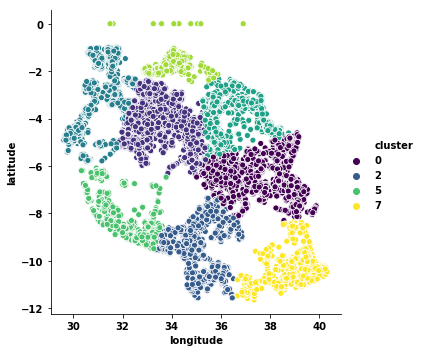

In [22]:
from sklearn.cluster import KMeans
kmeans = KMeans()
train['cluster'] = kmeans.fit_predict(train[['longitude', 'latitude']])
sns.relplot(x='longitude', y='latitude', hue='cluster', palette='viridis', data=train[train.longitude != 0]);

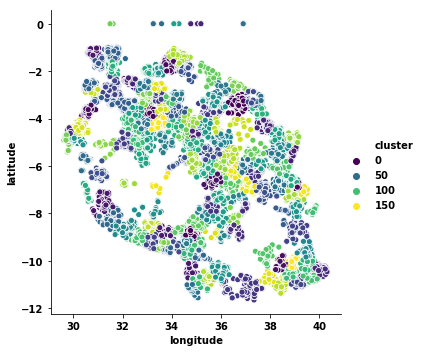

In [23]:
kmeans = KMeans(n_clusters=144)
train['cluster'] = kmeans.fit_predict(train[['longitude', 'latitude']])
sns.relplot(x='longitude', y='latitude', hue='cluster', palette='viridis', data=train[train.longitude != 0]);

In [24]:
val.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'region', 'lga', 'population', 'scheme_management',
       'construction_year', 'extraction_type', 'management', 'payment_type',
       'quality_group', 'quantity', 'source', 'waterpoint_type',
       'year_recorded', 'amount_tsh_above_1000',
       'water_quality_good_and_seasonal', 'water_quality_good_and_dry',
       'water_quality_good_and_insufficient', 'water_quality_good_and_enough',
       'water_quality_good', 'age', 'years_since_inspection', 'x_coordinate',
       'y_coordinate', 'z_coordinate', 'status_group'],
      dtype='object')

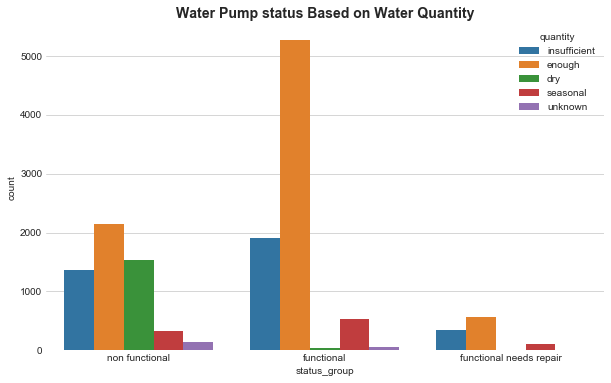

In [57]:
plt.style.context('fivethirtyeight')
plt.figure(figsize=(10, 6))

ax = sns.countplot(x='status_group', hue='quantity', data=val);
plt.title('Water Pump status Based on Water Quantity', fontsize=14, fontweight='semibold')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

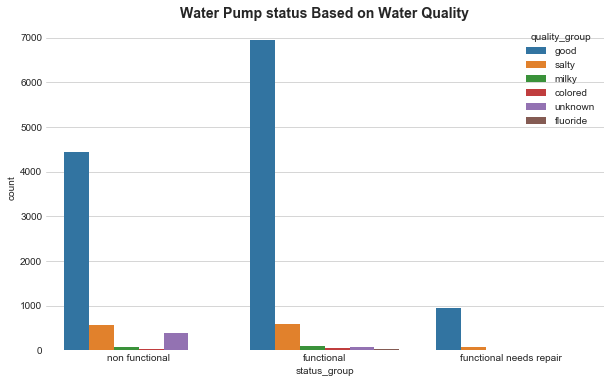

In [58]:
plt.style.context('fivethirtyeight')
plt.figure(figsize=(10, 6))

ax = sns.countplot(x='status_group', hue='quality_group', data=val);
plt.title('Water Pump status Based on Water Quality', fontsize=14, fontweight='semibold')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)